# Рекомендательные системы. 
## Ранжирование и Гибридные рекоммендательные системы

## Домашнее задание

1) Прочитать статьи про BPR, WARP loss

2) Сделать грид серч текущей модели

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# from src.metrics import precision_at_k, recall_at_k
from utils import prefilter_items

/Users/eugene/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


### Загрузка и подготовка данных

In [2]:
data = pd.read_csv('retail_train.csv')

item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [4]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


### Фильтрация данных

In [5]:
n_items_train_before = data_train['item_id'].nunique()
n_items_test_before = data_test['item_id'].nunique()
n_users_train_before = data_train['user_id'].nunique()
n_users_test_before = data_test['user_id'].nunique()

data_train_filtered = prefilter_items(data_train, take_n_popular=5000, item_features=item_features)
data_test_filtered = prefilter_items(data_test, take_n_popular=5000, item_features=item_features)

n_items_train_after = data_train_filtered['item_id'].nunique()
n_items_test_after = data_test_filtered['item_id'].nunique()
n_users_train_after = data_train_filtered['user_id'].nunique()
n_users_test_after = data_test_filtered['user_id'].nunique()
print('Decreased # items_train from {} to {}'.format(n_items_train_before, n_items_train_after))
print('Decreased # items_test from {} to {}'.format(n_items_test_before, n_items_test_after))
print('Decreased # users_train from {} to {}'.format(n_users_train_before, n_users_train_after))
print('Decreased # users_test from {} to {}'.format(n_users_test_before, n_users_test_after))

Decreased # items_train from 86865 to 5001
Decreased # items_test from 24329 to 5001
Decreased # users_train from 2499 to 2497
Decreased # users_test from 2042 to 1990


In [6]:
# Проверим наличие новых пользователей в тестовом наборе
new_test_users_ids = set(data_test['user_id']) - set(data_train['user_id'])
new_test_users_ids

set()

### Подготовка матриц взаимодействия

In [7]:
# подготовка матрицы взаимодействия для тренировочного датасета
user_item_matrix = pd.pivot_table(data_train_filtered, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,117847,818981,819255,819308,819400,819487,819590,819594,819840,819845,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# подготовка матрицы взаимодействия для тестового датасета
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]

test_user_item_matrix = pd.pivot_table(data_test_filtered, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float) # необходимый тип матрицы для implicit
test_user_item_matrix.head(2)

item_id,819210,819308,819423,819487,819840,819845,819978,820321,820347,820352,...,17381676,17381995,17827241,17900997,17901020,17903379,17903423,17959083,18000012,18024556
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# подготовка таблиц соответствия реальных и матричных идентификаторов пользователей и товаров
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

### Подготовка дополнительных признаков для пользователй и товаров

In [10]:
# дополнительные признаки для пользователей
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)
user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# дополнительные признаки для товаров
item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

item_feat.head(2)

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
item_id,,,,,,
117847,450.0,NUTRITION,National,REFRIGERATED,SOY/RICE MILK,64 OZ
818981,194.0,GROCERY,National,COLD CEREAL,ALL FAMILY CEREAL,10.4 OZ


### Преобразование категориальных признаков

In [12]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

### Инициализация  и обучение модели

In [13]:
model = LightFM(no_components=40,
                 loss='bpr',
                #loss='warp',
                learning_rate=0.05, 
                item_alpha=0.1,
                user_alpha=0.1, 
                random_state=42)

In [14]:
%%time

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4,
          verbose=False) 

CPU times: user 28.2 s, sys: 127 ms, total: 28.4 s
Wall time: 31.1 s


### Оценка качества

In [15]:
# для тренировочного набора

train_precision = precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision

0.21097319

In [16]:
# для тестового набора
test_precision = precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

test_precision

0.0024120605

### GridSearch

Будем подбирать параметры:
- no_components,
- loss,
- learning_rate,
- item_alpha,
- user_alpha

In [49]:
# зададим диапазоны изменений гиперпараметров
no_components_list = [20, 30, 40, 50, 60, 70, 80]
loss_list = ['bpr', 'warp'] 
learning_rate_list = [0.01, 0.05, 0.1, 0.15]
item_alpha_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
user_alpha_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [75]:
# исследуем влияние количества факторов
metric_list = []
metric_list_test = []
for no_components in no_components_list:
    model = LightFM(no_components=no_components,
                 loss='bpr',
                #loss='warp',
                learning_rate=0.05, 
                item_alpha=0.1,
                user_alpha=0.1, 
                random_state=42)
    model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4,
          verbose=False) 
    
    metric_list.append(precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean())
    metric_list_test.append(precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean())

In [88]:
train_metric = pd.DataFrame.from_dict(dict(zip(no_components_list, metric_list)), orient='index', columns=['Precision@5_train'])
test_metric = pd.DataFrame.from_dict(dict(zip(no_components_list, metric_list_test)), orient='index', columns=['Precision@5_test'])
ttm = pd.concat([factors_metric, factors_metric_test], axis=1)
ttm

,Precision@5_train,Precision@5_test
20,0.211694,0.002312
30,0.209371,0.002714
40,0.210973,0.002412
50,0.210973,0.002412
60,0.210973,0.002412
70,0.210813,0.002412
80,0.204646,0.002312


<AxesSubplot:title={'center':'Зависимость метрики от количества факторов'}, xlabel='Factors number'>

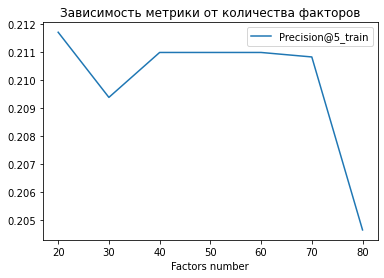

In [89]:
train_metric.plot(title = 'Зависимость метрики от количества факторов', xlabel='Factors number')

<AxesSubplot:title={'center':'Зависимость метрики от количества факторов'}, xlabel='Factors number'>

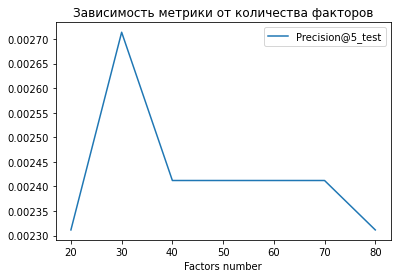

In [90]:
test_metric.plot(title = 'Зависимость метрики от количества факторов', xlabel='Factors number')

Исследуем влияние функции потерь

In [91]:
metric_list = []
metric_list_test = []
no_components = 30
for loss in loss_list:
    model = LightFM(no_components=no_components,
                 loss=loss,
                #loss='warp',
                learning_rate=0.05, 
                item_alpha=0.1,
                user_alpha=0.1, 
                random_state=42)
    model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4,
          verbose=False) 
    
    metric_list.append(precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean())
    metric_list_test.append(precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                             user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                             item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                             k=5).mean())

In [94]:
train_metric = pd.DataFrame.from_dict(dict(zip(loss_list, metric_list)), orient='index', columns=['Precision@5_train'])
test_metric = pd.DataFrame.from_dict(dict(zip(loss_list, metric_list_test)), orient='index', columns=['Precision@5_test'])
ttm = pd.concat([train_metric, test_metric], axis=1)
ttm

,Precision@5_train,Precision@5_test
bpr,0.209371,0.002714
warp,0.294113,0.002814


<AxesSubplot:title={'center':'Зависимость метрики от функции потерь'}, xlabel='Loss function'>

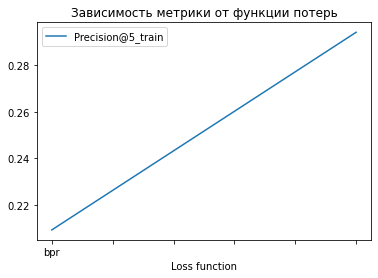

In [95]:
train_metric.plot(title = 'Зависимость метрики от функции потерь', xlabel='Loss function')

<AxesSubplot:title={'center':'Зависимость метрики от функции потерь'}, xlabel='Loss function'>

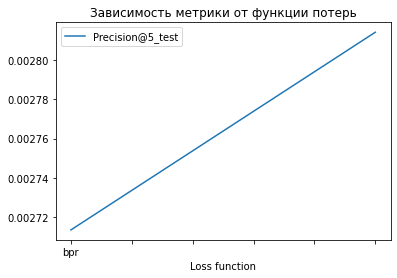

In [96]:
test_metric.plot(title = 'Зависимость метрики от функции потерь', xlabel='Loss function')

Исследуем learning_rate

In [97]:
metric_list = []
metric_list_test = []
no_components = 30
loss = 'warp'
for learning_rate in learning_rate_list:
    model = LightFM(no_components=no_components,
                 loss=loss,
                #loss='warp',
                learning_rate=learning_rate, 
                item_alpha=0.1,
                user_alpha=0.1, 
                random_state=42)
    model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4,
          verbose=False) 
    
    metric_list.append(precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean())
    metric_list_test.append(precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean())

In [98]:
train_metric = pd.DataFrame.from_dict(dict(zip(learning_rate_list, metric_list)), orient='index', columns=['Precision@5_train'])
test_metric = pd.DataFrame.from_dict(dict(zip(learning_rate_list, metric_list_test)), orient='index', columns=['Precision@5_test'])
ttm = pd.concat([train_metric, test_metric], axis=1)
ttm

,Precision@5_train,Precision@5_test
0.01,0.136884,0.001608
0.05,0.294113,0.002814
0.10,0.435162,0.002814
0.15,0.172367,0.003417


<AxesSubplot:title={'center':'Зависимость метрики от скорости обучения'}, xlabel='Learning Rate'>

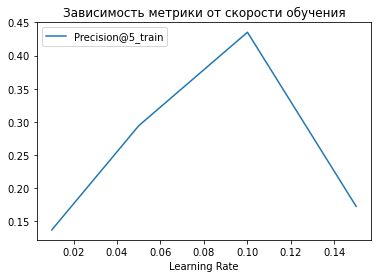

In [99]:
train_metric.plot(title = 'Зависимость метрики от скорости обучения', xlabel='Learning Rate')

<AxesSubplot:title={'center':'Зависимость метрики от скорости обучения'}, xlabel='Learning Rate'>

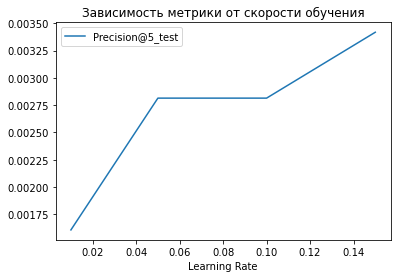

In [100]:
test_metric.plot(title = 'Зависимость метрики от скорости обучения', xlabel='Learning Rate')

Исследуем item alpha

In [101]:
metric_list = []
metric_list_test = []
no_components = 40
loss = 'warp'
learning_rate = 0.15
for item_alpha in item_alpha_list:
    model = LightFM(no_components=no_components,
                 loss=loss,
                #loss='warp',
                learning_rate=learning_rate, 
                item_alpha=item_alpha,
                user_alpha=0.1, 
                random_state=42)
    model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4,
          verbose=False) 
    
    metric_list.append(precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean())
    metric_list_test.append(precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean())

In [102]:
train_metric = pd.DataFrame.from_dict(dict(zip(item_alpha_list, metric_list)), orient='index', columns=['Precision@5_train'])
test_metric = pd.DataFrame.from_dict(dict(zip(item_alpha_list, metric_list_test)), orient='index', columns=['Precision@5_test'])
ttm = pd.concat([train_metric, test_metric], axis=1)
ttm

,Precision@5_train,Precision@5_test
0.01,0.086984,0.002211
0.05,0.180937,0.001407
0.10,0.158590,0.003819
0.20,0.222827,0.013467
0.30,0.208731,0.002915
0.40,0.211454,0.002211
0.50,0.223468,0.012764


<AxesSubplot:title={'center':'Зависимость метрики от item alpha'}, xlabel='Item alpha'>

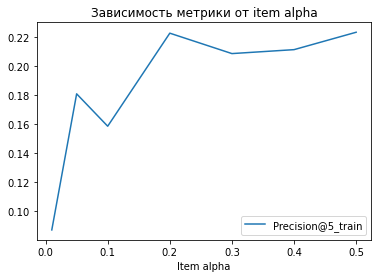

In [103]:
train_metric.plot(title = 'Зависимость метрики от item alpha', xlabel='Item alpha')

<AxesSubplot:title={'center':'Зависимость метрики от item alpha'}, xlabel='Item alpha'>

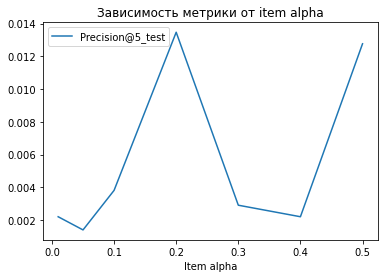

In [104]:
test_metric.plot(title = 'Зависимость метрики от item alpha', xlabel='Item alpha')

Исследуем user alpha

In [105]:
metric_list = []
metric_list_test = []
no_components = 40
loss = 'warp'
learning_rate = 0.15
item_alpha = 0.5
for user_alpha in user_alpha_list:
    model = LightFM(no_components=no_components,
                 loss=loss,
                #loss='warp',
                learning_rate=learning_rate, 
                item_alpha=item_alpha,
                user_alpha=user_alpha, 
                random_state=42)
    model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4,
          verbose=False) 
    
    metric_list.append(precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean())
    metric_list_test.append(precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean())

In [106]:
train_metric = pd.DataFrame.from_dict(dict(zip(user_alpha_list, metric_list)), orient='index', columns=['Precision@5_train'])
test_metric = pd.DataFrame.from_dict(dict(zip(user_alpha_list, metric_list_test)), orient='index', columns=['Precision@5_test'])
ttm = pd.concat([train_metric, test_metric], axis=1)
ttm

,Precision@5_train,Precision@5_test
0.01,0.221786,0.012362
0.05,0.222507,0.011457
0.10,0.223468,0.012764
0.20,0.205527,0.002211
0.30,0.210973,0.002412
0.40,0.210733,0.002412
0.50,0.210973,0.002412


<AxesSubplot:title={'center':'Зависимость метрики от user alpha'}, xlabel='User alpha'>

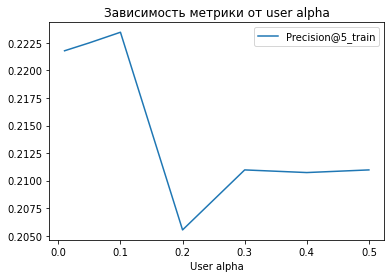

In [107]:
train_metric.plot(title = 'Зависимость метрики от user alpha', xlabel='User alpha')

<AxesSubplot:title={'center':'Зависимость метрики от user alpha'}, xlabel='User alpha'>

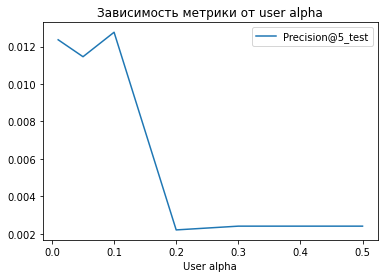

In [108]:
test_metric.plot(title = 'Зависимость метрики от user alpha', xlabel='User alpha')

Обучим модель с лучшими гиперпараметрами и проверим на тестовом наборе данных

In [109]:
no_components = 40
loss = 'warp'
learning_rate = 0.15
item_alpha = 0.5
user_alpha = 0.1

In [110]:
model = LightFM(no_components=no_components,
                 loss=loss,
                #loss='warp',
                learning_rate=learning_rate, 
                item_alpha=item_alpha,
                user_alpha=user_alpha, 
                random_state=42)

In [111]:
model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4,
          verbose=False) 

In [112]:
# для тренировочного набора

train_precision = precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision

0.22346818

In [113]:
# для тестового набора
test_precision = precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

test_precision

0.01276382

Попробуем убрать веса признаков при обучении

In [114]:
model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4,
          verbose=False) 

In [115]:
# для тренировочного набора

train_precision = precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision

0.2065679

In [116]:
# для тестового набора
test_precision = precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

test_precision

0.0022110553

### Выводы

Наилучшие гиперпараметры:
no_components = 40
loss = 'warp'
learning_rate = 0.15
item_alpha = 0.5
user_alpha = 0.1

При обучении используем простейшее взвешивание.
Функция потерь WARP дает лучшие результаты. Довольно сильная заисимость метрик от leraning_rate.